In [13]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
amitvkulkarni_lifestyle_factors_influencing_osteoporosis_path = kagglehub.dataset_download('amitvkulkarni/lifestyle-factors-influencing-osteoporosis')

print('Data source import complete.')


Data source import complete.


# Osteoporosis Prediction Dataset Exploration

In this notebook, we will explore the Osteoporosis prediction dataset available on Kaggle, aiming to develop a predictive model for identifying individuals at risk of osteoporosis. This dataset comprises various clinical parameters and demographic information. We will train an XGBClassifier and later optimize its accuracy by finding the best parameters using GridSearchCV.

## Import Libraries


In [14]:
# Scientific Libraries
import numpy as np
import pandas as pd
from tabulate import tabulate

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             classification_report,
                             precision_score,
                             recall_score,
                             f1_score)

# Iterate through files in the specified directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Load the Osteoporosis Dataset

In this section, we will load the Osteoporosis dataset, which comprises comprehensive information on health factors influencing osteoporosis development. The dataset includes demographic details such as age, gender, and ethnicity, lifestyle choices including diet and exercise habits, medical history such as previous fractures and family history of osteoporosis, and bone health indicators like bone mineral density (BMD) measurements.

In [15]:
# Download the dataset using kagglehub
amitvkulkarni_lifestyle_factors_influencing_osteoporosis_path = kagglehub.dataset_download('amitvkulkarni/lifestyle-factors-influencing-osteoporosis')

# Construct the full path to the CSV file using the downloaded path
# Assuming the CSV file is named "osteoporosis.csv"
file_path = os.path.join(amitvkulkarni_lifestyle_factors_influencing_osteoporosis_path, "osteoporosis.csv")

# Read the CSV file
dataset = pd.read_csv(file_path)
dataset.drop(columns=['Id'], inplace=True)

dataset.head()

,Age,Gender,Hormonal Changes,Family History,Race/Ethnicity,Body Weight,Calcium Intake,Vitamin D Intake,Physical Activity,Smoking,Alcohol Consumption,Medical Conditions,Medications,Prior Fractures,Osteoporosis
0,69,Female,Normal,Yes,Asian,Underweight,Low,Sufficient,Sedentary,Yes,Moderate,Rheumatoid Arthritis,Corticosteroids,Yes,1
1,32,Female,Normal,Yes,Asian,Underweight,Low,Sufficient,Sedentary,No,NaN,NaN,NaN,Yes,1
2,89,Female,Postmenopausal,No,Caucasian,Normal,Adequate,Sufficient,Active,No,Moderate,Hyperthyroidism,Corticosteroids,No,1
3,78,Female,Normal,No,Caucasian,Underweight,Adequate,Insufficient,Sedentary,Yes,NaN,Rheumatoid Arthritis,Corticosteroids,No,1
4,38,Male,Postmenopausal,Yes,African American,Normal,Low,Sufficient,Active,Yes,NaN,Rheumatoid Arthritis,NaN,Yes,1


## Exploratory Data Analysis (EDA) on the Osteoporosis Dataset


In [16]:
dataset.fillna("NA", inplace = True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1958 non-null   int64 
 1   Gender               1958 non-null   object
 2   Hormonal Changes     1958 non-null   object
 3   Family History       1958 non-null   object
 4   Race/Ethnicity       1958 non-null   object
 5   Body Weight          1958 non-null   object
 6   Calcium Intake       1958 non-null   object
 7   Vitamin D Intake     1958 non-null   object
 8   Physical Activity    1958 non-null   object
 9   Smoking              1958 non-null   object
 10  Alcohol Consumption  1958 non-null   object
 11  Medical Conditions   1958 non-null   object
 12  Medications          1958 non-null   object
 13  Prior Fractures      1958 non-null   object
 14  Osteoporosis         1958 non-null   int64 
dtypes: int64(2), object(13)
memory usage: 229.6+ KB


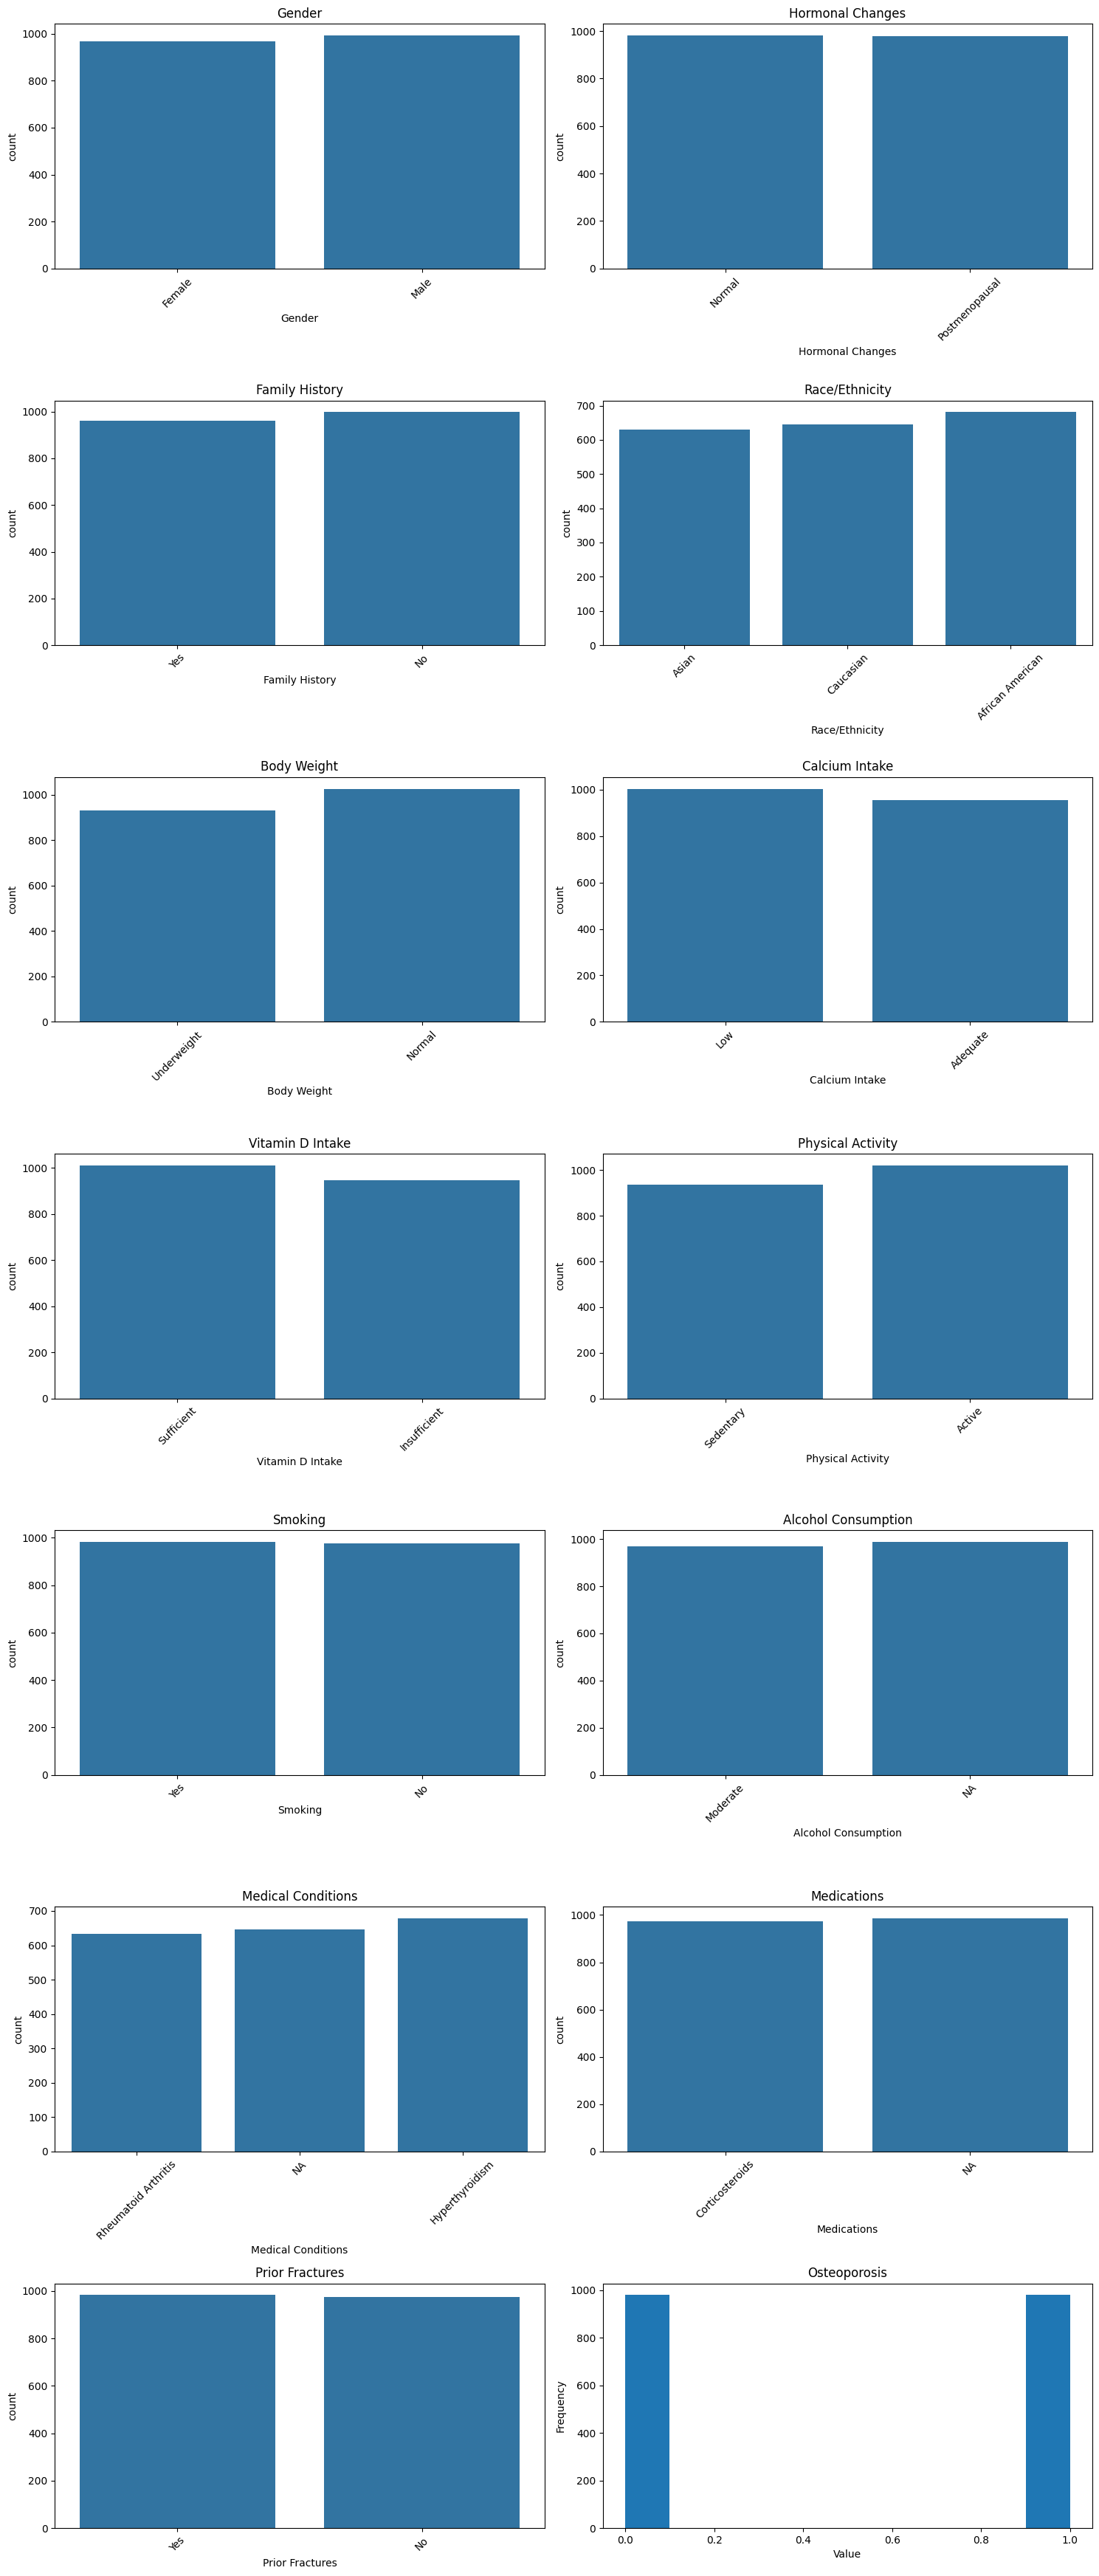

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of columns in each row
num_columns_per_row = 2

# Calculate the number of rows needed
num_rows = -(-len(dataset.columns[1:]) // num_columns_per_row)

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns_per_row, figsize=(15, 5 * num_rows))

# Flatten the axes array to make iteration easier
axes = axes.flatten()

# Iterate over each column
for i, column in enumerate(dataset.columns[1:]):
    # Check data type to determine visualization type
    if dataset[column].dtype == 'object':  # Categorical data
        # Create a bar plot using Seaborn
        sns.countplot(x=column, data=dataset, ax=axes[i])
        axes[i].set_title(column)
        axes[i].tick_params(axis='x', rotation=45)
    else:  # Numerical data
        # Create a histogram using Matplotlib
        axes[i].hist(dataset[column], bins=10)
        axes[i].set_title(column)
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Frequency")

# Remove empty subplot if present
if len(dataset.columns[1:]) % num_columns_per_row != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

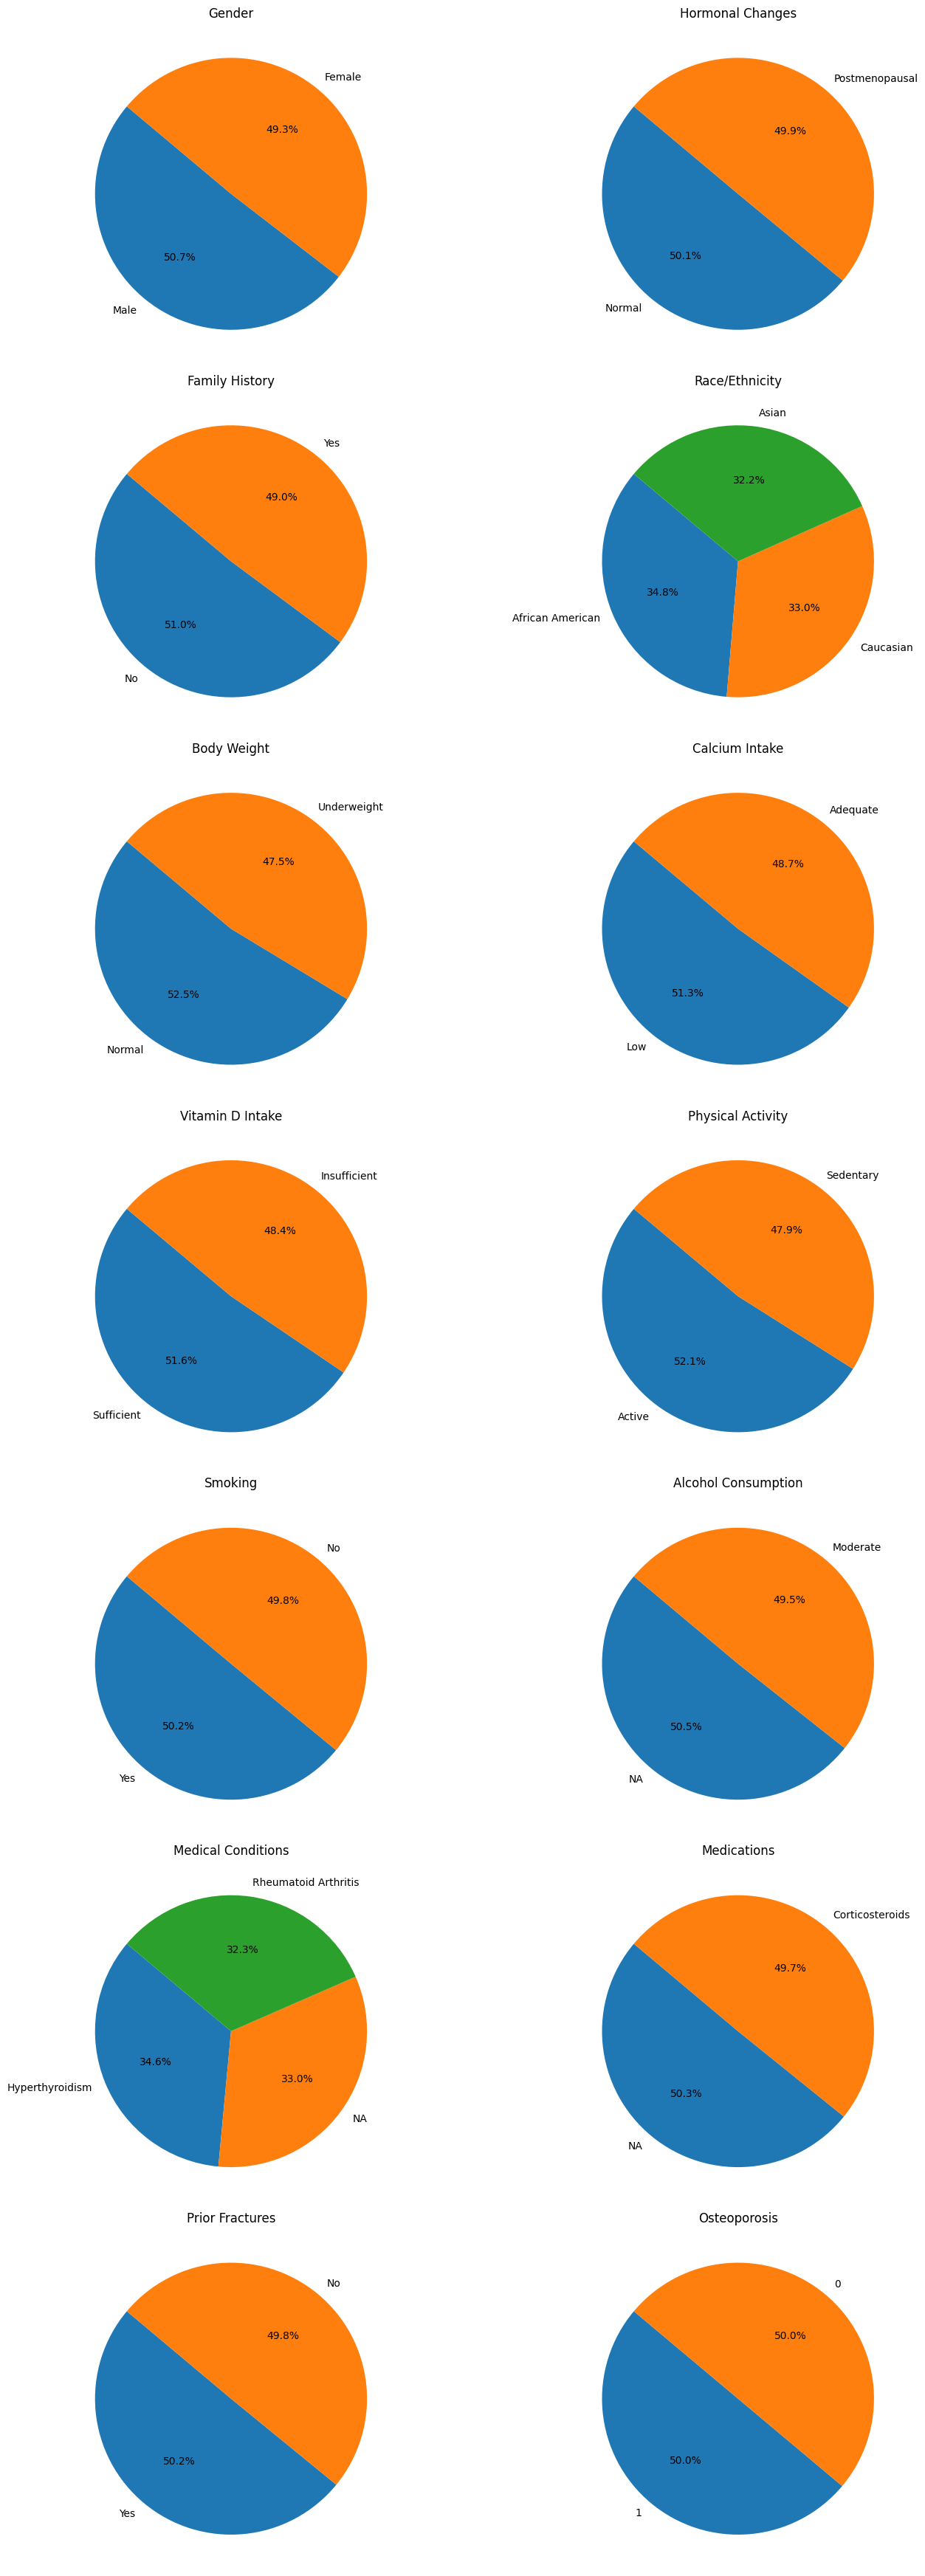

In [18]:
def value_count(dataset, column):
    counts = dataset[column].value_counts()
    return counts

# Define the number of columns in each row
num_columns_per_row = 2

# Calculate the number of rows needed
num_rows = -(-len(dataset.columns[1:]) // num_columns_per_row)

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns_per_row, figsize=(15, 5*num_rows))

# Flatten the axes array to make iteration easier
axes = axes.flatten()

# Iterate over each column
for i, column in enumerate(dataset.columns[1:]):
    counts = value_count(dataset, column)
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(column)

# Remove empty subplot if present
if len(dataset.columns[1:]) % num_columns_per_row != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [19]:
encoder = LabelEncoder()
for col in dataset.columns[1:-1]:
    dataset[col] = encoder.fit_transform(dataset[col].values)

dataset.head()

,Age,Gender,Hormonal Changes,Family History,Race/Ethnicity,Body Weight,Calcium Intake,Vitamin D Intake,Physical Activity,Smoking,Alcohol Consumption,Medical Conditions,Medications,Prior Fractures,Osteoporosis
0,69,0,0,1,1,1,1,1,1,1,0,2,0,1,1
1,32,0,0,1,1,1,1,1,1,0,1,1,1,1,1
2,89,0,1,0,2,0,0,1,0,0,0,0,0,0,1
3,78,0,0,0,2,1,0,0,1,1,1,2,0,0,1
4,38,1,1,1,0,0,1,1,0,1,1,2,1,1,1


## Data Preparation



In [20]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns = ['Osteoporosis']),
                                                    dataset['Osteoporosis'],
                                                    test_size = 0.2,
                                                    random_state = 0)

## Hyperparameter Tuning with Grid Search


In [21]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.1, 1, 10, 100]
}

# Initialize XGBoost classifier
model = XGBClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

Best Parameters: {'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.1, 'reg_lambda': 10}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Model Evaluation




In [22]:
def calculate_classification_metrics(y_train, y_train_hat, y_test, y_test_hat):
    # Calculate metrics
    accuracy_train = accuracy_score(y_train, y_train_hat)
    accuracy_test = accuracy_score(y_test, y_test_hat)
    precision_train = precision_score(y_train, y_train_hat)
    precision_test = precision_score(y_test, y_test_hat)
    recall_train = recall_score(y_train, y_train_hat)
    recall_test = recall_score(y_test, y_test_hat)
    f1_train = f1_score(y_train, y_train_hat)
    f1_test = f1_score(y_test, y_test_hat)

    # Create DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Train': [accuracy_train, precision_train, recall_train, f1_train],
        'Test': [accuracy_test, precision_test, recall_test, f1_test]
    })

    return metrics_df

In [23]:
y_train_hat = best_model.predict(X_train)
y_test_hat = best_model.predict(X_test)

best_model_metrics = calculate_classification_metrics(y_train, y_train_hat, y_test, y_test_hat)
best_model_metrics

,Metric,Train,Test
0,Accuracy,0.915070,0.915816
1,Precision,0.998454,1.000000
2,Recall,0.830334,0.835821
3,F1 Score,0.906667,0.910569


In [24]:
import joblib

# Save the model to a file
best_model = grid_search.best_estimator_
model_filename = 'osteoporosis_model.joblib'
joblib.dump(best_model, model_filename)

print(f"Model saved to: {model_filename}")

Model saved to: osteoporosis_model.joblib
